# Supervised Fine-Tuning on LLM

In [ ]:
!pip install transformers accelerate datasets trl bitsandbytes -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.2/376.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

import os
os.environ["WANDB_DISABLED"] = "True"

# Load Dataset

In [ ]:
from datasets import Dataset

data = [
    {"text": "### Instruction: \nWho is Pedro Sanchez? \n### Response: \nAn spanish politician", "input": "### Instruction: \nWho is Pedro Sanchez?"},
]
dataset = Dataset.from_list(data)
dataset

Dataset({
    features: ['text', 'input'],
    num_rows: 1
})

# Load Model

In [ ]:
!rm -rf /content/EleutherAI/

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
model_name = "EleutherAI/gpt-neo-125m"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [ ]:
for item in dataset:
    inputs = tokenizer(item["input"], return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=10, eos_token_id=tokenizer.eos_token_id,)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


### Instruction: 
Who is Pedro Sanchez?

A:

I'm not sure


# Fine-Tuning: SFT

In [ ]:
from trl import SFTConfig, SFTTrainer

training_args = SFTConfig(
    output_dir=model_name,
    num_train_epochs=50,
    report_to=None,
    logging_steps=1,
    logging_strategy="steps"
  )

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    args=training_args
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Adding EOS to train dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

Step,Training Loss
1,5.042500
2,4.954000
3,4.796400
4,4.711500
5,4.386000
6,4.257000
7,4.178400
8,3.437600
9,3.388900
10,3.320500


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=50, training_loss=1.6070455980207772, metrics={'train_runtime': 17.6365, 'train_samples_per_second': 2.835, 'train_steps_per_second': 2.835, 'total_flos': 561187123200.0, 'train_loss': 1.6070455980207772})

Plot loss function

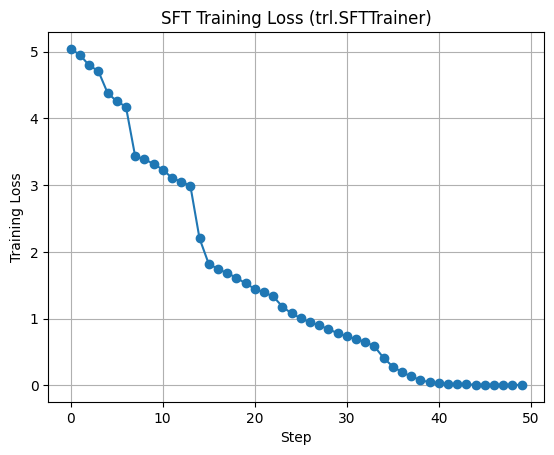

In [ ]:
import json
import matplotlib.pyplot as plt

logs = json.load(open("/content/EleutherAI/gpt-neo-125m/checkpoint-50/trainer_state.json", "r"))

losses = [entry["loss"] for entry in logs["log_history"] if "loss" in entry]
steps = list(range(len(losses)))

plt.plot(steps, losses,"-o")
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("SFT Training Loss (trl.SFTTrainer)")
plt.grid()
plt.show()

Test new inference

In [ ]:
for item in dataset:
    inputs = tokenizer(item["input"], return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


### Instruction: 
Who is Pedro Sanchez? 
### Response: 
An spanish politician
